## Spectral analysis during Sample phase

<br>


### Prepare environment

In [6]:
import os
import re
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import wabrnings
from scipy.stats import friedmanchisquare, wilcoxon
from scipy.signal import iirnotch, filtfilt, lfilter
from spectral_connectivity import Multitaper, Connectivity
warnings.filterwarnings('ignore')
%matplotlib inline

In [184]:
def load_arrays(path, filename1, filename2, filename3):
    """
    Load three arrays from disk in a specified directory, where the first two are 2D arrays and the third is a 4D array.
    Parameters:
    - path: Directory path where arrays are saved
    - filename1: Filename for the first 2D array
    - filename2: Filename for the second 2D array
    - filename3: Filename for the third 4D array
    Returns:
    - array1: Loaded 2D numpy array from filename1
    - array2: Loaded 2D numpy array from filename2
    - array3: Loaded 4D numpy array from filename3
    """

    # Load arrays from .npy files
    array1 = np.load(os.path.join(path, filename1))
    array2 = np.load(os.path.join(path, filename2))
    array3 = np.load(os.path.join(path, filename3))
    return array1, array2, array3


def zscore_4d_power(data):
    """
    Z-score the power values in a 4D array by each sample.
    Parameters:
    - data: 4D numpy array of shape (time_bins, trials, freq_bins, samples/tetrodes)
    Returns:
    - 4D numpy array with z-scored power values, maintaining the same shape as the input data
    """
    # Calculate mean and std withn trial and tetrode (across time_bins and freq_bins)
    mean = np.mean(data, axis=(0, 2), keepdims=True)
    std = np.std(data, axis=(0, 2), keepdims=True)   
    return (data - mean) / std  

def remove_outliers_zscored(data, z_threshold):
    """
    Detect and remove outliers from a z-scored 4D array by substituting outliers with the average
    within their respective trial and tetrode. Provides a comparative visualization of the power 
    distributions before and after outlier removal.
    Parameters:
    - data: 4D numpy array of z-scored power values with shape (time, trials, frequencies, tetrodes)
    - z_threshold: The z-score threshold for detecting outliers
    Returns:
    - cleaned_data: 4D numpy array with outliers removed, maintaining the same shape
    - percentage_removed: Percentage of data points removed as outliers
    """
    
    # Copy data to avoid modifying the original
    data_cleaned = np.copy(data)   
    # Calculate the percentage of outliers and replace them within their respective trial and tetrode
    total_elements = np.prod(data.shape)
    outliers_count = 0

    for trial in range(data.shape[1]):
        for tetrode in range(data.shape[3]):
            # Isolate the data slice for the current trial and tetrode
            slice_data = data[:, trial, :, tetrode]

            # Identify outliers in this slice
            outliers = np.abs(slice_data) > z_threshold

            # Count the outliers
            outliers_count += np.sum(outliers)

            # Compute the mean of the non-outlier values in this slice
            slice_mean = np.nanmean(slice_data[~outliers])

            # Replace outliers with the slice mean
            slice_data[outliers] = slice_mean

            # Assign the cleaned slice back to the cleaned_data array
            data_cleaned[:, trial, :, tetrode] = slice_data

    # Calculate the percentage of data points removed as outliers
    percentage_removed = (outliers_count / total_elements) * 100
    print(f"Percentage of data points replaced as outliers: {percentage_removed:.2f}%")
    # Comparative visualization of power distributions
    
    plt.figure(figsize=(12, 6))  
    # Before removal
    plt.subplot(1, 2, 1)
    sns.histplot(data.flatten(), bins=50, kde=True, color='blue')
    plt.title('Power Distribution Before Outlier Removal')
    plt.xlabel('Z-Score')
    plt.ylabel('Frequency')
    # After removal
    plt.subplot(1, 2, 2)
    sns.histplot(data_cleaned.flatten(), bins=50, kde=True, color='green')
    plt.title('Power Distribution After Outlier Removal')
    plt.xlabel('Z-Score')
    plt.ylabel('Frequency')  
    plt.tight_layout()
    plt.show()

    return data_cleaned

def average_power(data):
    """
    Calculate the average power and standard deviation.
    Parameters:
    - data: 4D numpy array with shape (time_bins, trials, freq_bins, samples)
    Returns:
    - avg_power: 2D numpy array of shape (time_bins, freq_bins) with average power
    - std_power: 2D numpy array of shape (time_bins, freq_bins) with standard deviation of power
    """
    # Calculate average power across tetrodes (axis3) and trials (axis1)
    avg_power = np.mean(data, axis=(3, 1)) 
    # Calculate standard deviation of power across tetrodes (axis3) and trials (axis1)
    std_power = np.std(data, axis=(3,1)) 
    # Calculate median power
    median_power = np.median(data, axis=(3,1))
    return avg_power, std_power, median_power

def plot_psd_band(time_bins, frequency_bins, power, x_tick_labels=None, ylim=None, vmin=None, vmax=None):
    """
    Create a Power Spectral Density (PSD) plot using imshow with Gaussian interpolation.

    Parameters:
    - time_bins: 1D numpy array of time bins
    - frequency_bins: 1D numpy array of frequency bins
    - power: 2D numpy array of power values with shape (time_bins, frequency_bins)
    - x_tick_labels: List or array of custom labels for the x-axis (time bins)
    - ylim: Tuple specifying the y-axis limits (min, max) in frequency_bins or None to auto-scale
    - vmin: Minimum value for the color scale or None to auto-scale based on filtered data
    - vmax: Maximum value for the color scale or None to auto-scale based on filtered data
    """
    # Ensure inputs are correctly shaped
    if power.shape[0] != len(time_bins) or power.shape[1] != len(frequency_bins):
        raise ValueError("Shape of power array must match the length of time_bins and frequency_bins.")

    # Filter time_bins and corresponding power values to only include those between 0 and 1
    valid_indices = np.where((time_bins >= 0) & (time_bins <= 1))[0]
    filtered_time_bins = time_bins[valid_indices]
    filtered_power = power[valid_indices]

    # Filter the power and frequency_bins based on ylim
    ylim_indices = [np.searchsorted(frequency_bins, val) for val in ylim]
    filtered_frequency_bins = frequency_bins[ylim_indices[0]:ylim_indices[1]]
    filtered_power = filtered_power[:, ylim_indices[0]:ylim_indices[1]]

    # Recalculate vmin and vmax based on the filtered power data if not provided
    if vmin is None:
        vmin = np.min(filtered_power)
    if vmax is None:
        vmax = np.max(filtered_power)

    # Set up the plot
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 4), dpi=300)

    # Plot using imshow
    plt.imshow(
        filtered_power.T,  # Transpose to match the orientation (time on x-axis, frequency on y-axis)
        aspect='auto',  # Automatic aspect ratio
        cmap='jet',  # Color map
        origin='lower',  # Set origin to lower-left
        interpolation='gaussian',  # Use Gaussian interpolation
        vmin=vmin,  # Set the minimum value for the color scale
        vmax=vmax   # Set the maximum value for the color scale
    )

    # Add colorbar and labels
    plt.colorbar(label='Power')
    plt.xlabel('Time Bins')
    plt.ylabel('Frequency Bins')

    # Set y-ticks at every 5th tick, starting from 0 (for the filtered frequency bins)
    y_ticks = np.arange(0, len(filtered_frequency_bins), 5)   
    y_labels = (np.round(filtered_frequency_bins[::5], 2)).astype(int)  # Label every 5th frequency
    plt.yticks(ticks=y_ticks, labels=y_labels)

    # Set x-ticks using the provided x_tick_labels if available, rounded to one decimal place
    if x_tick_labels is not None:
        rounded_labels = [round(label, 2) for label in x_tick_labels]  # Round to one decimal place
        plt.xticks(ticks=np.arange(len(rounded_labels)), labels=rounded_labels)

    # Add vertical white dotted line where time_bin == 0.5
    if 0.5 in filtered_time_bins:
        time_bin_index = np.searchsorted(filtered_time_bins, 0.5)  # Find index where time_bin == 0.5
        plt.axvline(x=time_bin_index, color='white', linestyle='--', linewidth=2)

    # Add title and show the plot
    plt.title('Power Spectral Density (PSD)')
    plt.grid(False)
    sns.despine()


    print('Filtered Frequency bins: {}'.format(filtered_frequency_bins))
    print('Time bins: {}'.format(filtered_time_bins))
    
    
def convert_to_long_format(
    data_array, time_bin_values, frequency_bin_values, ripple_labels, tetrode_labels,
    time_bin_label='time_bins', ripple_label='ripple_nr', freq_bin_label='frequency_bins', 
    tetrode_label='tetrode', power_label='power'
    ):
    """
    Convert a 4D array (time_bins, trials, frequency_bins, tetrodes) into a long-format pandas DataFrame.   
    Parameters:
    - data_array: 4D numpy array with shape (time_bins, trials, frequency_bins, tetrodes)
    - time_bin_values: 1D numpy array or list of time bin labels
    - frequency_bin_values: 1D numpy array or list of frequency bin labels
    - ripple_labels: An array with the ripple numbers 
    - tetrode_labels: An array with tetrode numbers
    - time_bin_label: Column name for time bins (default: 'time_bins')
    - trial_label: Column name for trials (default: 'trials')
    - freq_bin_label: Column name for frequency bins (default: 'frequency_bins')
    - tetrode_label: Column name for tetrodes (default: 'tetrode')
    - power_label: Column name for power values (default: 'power')
    
    Returns:
    - long_format_df: A pandas DataFrame in long format with columns [time_bins, trials, frequency_bins, tetrode, power]
    """
    # Get the shape of the input array
    time_bins = data_array.shape[0]
    ripples = data_array.shape[1]
    frequency_bins = data_array.shape[2]
    tetrodes = data_array.shape[3]
    
    # Check that time_bin_values and frequency_bin_values match the shape of data_array
    if len(time_bin_values) != time_bins:
        raise ValueError(f"Length of time_bin_values ({len(time_bin_values)}) does not match number of time bins ({time_bins})")
    if len(frequency_bin_values) != frequency_bins:
        raise ValueError(f"Length of frequency_bin_values ({len(frequency_bin_values)}) does not match number of frequency bins ({frequency_bins})")
    
    # Reshape the 4D array into a 1D array (flatten the array)
    reshaped_power = data_array.reshape(time_bins * ripples * frequency_bins * tetrodes)
    
    # Create multi-index for each combination of time_bins, trials, frequency_bins, and tetrodes
    multi_index = pd.MultiIndex.from_product(
        [time_bin_values, ripple_numbers, frequency_bin_values, tetrode_labels],
        names=[time_bin_label, ripple_label, freq_bin_label, tetrode_label]
    )
    
    # Create the dataframe with 'power' values and the multi-index
    long_format_df = pd.DataFrame({power_label: reshaped_power}, index=multi_index).reset_index() 
   
    return long_format_df






def plot_average_power(df, band=(4, 12), title=None, color='black', ylim=None, xlim=None):
    """
    Plot the power values with individual samples and the average overlay.

    Parameters:
    - df: DataFrame in long format with columns [time_bins, frequency_bins, power, ...]
    - band: Tuple to set the band to filter by
    - title: Title of the plot (default is band name)
    - color: Color of the average line (default is black)
    - ylim: Tuple to set the y-axis limits (e.g., (lower, upper))
    - xlim: Tuple to set the x-axis limits (e.g., (lower, upper))
    """
    # Set up the figure and axes
    plt.figure(figsize=(10, 6), dpi=300)
    sns.set(context='talk', style='white')

    # Filter the DataFrame by the specified frequency band
    df_filtered = df[df.frequency_bins.between(band[0], band[1])]

    # Plot the average line with standard deviation shading
    sns.lineplot(
        data=df_filtered,
        x='time_bins',
        y='power',
        color=color,
        legend=False,
        errorbar='sd',  # Shows standard deviation as shaded area
        estimator=np.mean
    )

    # Add a vertical dashed line at time_bins == 0
    plt.axvline(x=0, color='black', linestyle='--', linewidth=1.5)

    # Set x and y limits if provided
    if ylim:
        plt.ylim(ylim)
    if xlim:
        plt.xlim(xlim)

    # Add labels and title
    plt.xlabel('Time Bins')
    plt.ylabel('Power (z-score)')

    # Set title (either provided or default to band)
    plt.title(title if title else f'Power in {band[0]}-{band[1]} Hz Band')

    # Clean up the plot aesthetic
    sns.despine()
    plt.grid(False)
    plt.show()


def plot_median_power(df, band=(4, 12), title=None, color='black', ylim=None, xlim=None):
    """
    Plot the power values with the median and IQR overlay.

    Parameters:
    - df: DataFrame in long format with columns [time_bins, frequency_bins, power, ...]
    - band: Tuple to set the band to filter by
    - title: Title of the plot (default is band name)
    - color: Color of the median line (default is black)
    - ylim: Tuple to set the y-axis limits (e.g., (lower, upper))
    - xlim: Tuple to set the x-axis limits (e.g., (lower, upper))
    """
    # Set up the figure and axes
    plt.figure(figsize=(10, 6), dpi=300)
    sns.set(context='talk', style='white')

    # Filter the DataFrame by the specified frequency band
    df_filtered = df[df.frequency_bins.between(band[0], band[1])]

    # Calculate the median and IQR for each time bin
    iqr_data = df_filtered.groupby('time_bins')['power'].agg(['median', lambda x: np.percentile(x, 75) - np.percentile(x, 25)])
    iqr_data.columns = ['median', 'iqr']
    
    # Calculate lower and upper bounds of the IQR
    iqr_data['iqr_lower'] = iqr_data['median'] - iqr_data['iqr'] / 2
    iqr_data['iqr_upper'] = iqr_data['median'] + iqr_data['iqr'] / 2

    # Plot the median line
    plt.plot(iqr_data.index, iqr_data['median'], color=color, label='Median')

    # Plot the IQR shaded area
    plt.fill_between(iqr_data.index, iqr_data['iqr_lower'], iqr_data['iqr_upper'], color=color, alpha=0.3, label='IQR')

    # Add a vertical dashed line at time_bins == 0
    plt.axvline(x=0, color='black', linestyle='--', linewidth=1.5)

    # Set x and y limits if provided
    if ylim:
        plt.ylim(ylim)
    if xlim:
        plt.xlim(xlim)

    # Add labels and title
    plt.xlabel('Time Bins')
    plt.ylabel('Power (z-score)')

    # Set title (either provided or default to band)
    plt.title(title if title else f'Power in {band[0]}-{band[1]} Hz Band')

    # Clean up the plot aesthetic
    sns.despine()
    plt.grid(False)
    plt.legend(frameon=False)
    plt.show()

    

def analyze_specific_power_change(df, timepoint_pair, band=None, color='blue', bins=(0, 1, 0.1), xlim=None):
    """
    Analyze the distribution of paired power value changes between specified timepoints,
    and create a step histogram for the comparison.
    
    Arguments:
    df - The input dataframe with columns ['timepoint', 'power', 'frequency_bins'].
    timepoint_pair - Tuple of two timepoint labels to compare (e.g., ('Pre', 'Post')).
    band - Tuple to filter the dataframe by frequency_bins (e.g., (4, 8) for theta band), optional.
    color - Color for the step histogram line (default is 'blue').
    bins - Tuple specifying the range for the histogram bins (start, stop, step).
    xlim - Tuple specifying the limits for the x-axis (e.g., (min, max)), optional.    
    
    Returns:
    results - A dictionary with the average and median change, and the array of changes.
    """
    # Set the plot context and style
    sns.set(context='talk', style='white')
    
    # Validate timepoints in the dataframe
    tp1, tp2 = timepoint_pair
    if tp1 not in df['time_points'].unique() or tp2 not in df['time_points'].unique():
        raise ValueError("Both timepoints must be present in the dataframe.")
    
    # Filter dataframe by the given frequency band if provided
    if band:
        df = df[df['frequency_bins'].between(band[0], band[1])]
    
    # Filter the dataframe for the specified timepoints
    df_tp1 = df[df['time_points'] == tp1].reset_index(drop=True)
    df_tp2 = df[df['time_points'] == tp2].reset_index(drop=True)
    
    if len(df_tp1) != len(df_tp2):
        raise ValueError(f"Different number of samples for '{tp1}' and '{tp2}'")
    
    # Compute the change in power
    changes = df_tp2['power'].values - df_tp1['power'].values 
    
    
    # Calculate average and median change
    average_change = np.mean(changes)
    median_change = np.median(changes)
    
    # Save the results
    results = {
        'Changes': changes,
        'Average Change': average_change,
        'Median Change': median_change
    }
    
    # Define the bin range using the provided tuple (start, stop, step)
    bin_edges = np.arange(bins[0], bins[1] + bins[2], bins[2])

    # Plot the distribution of changes using a step-style histogram
    plt.figure(figsize=(8, 6))
    sns.histplot(changes, element='step', bins=bin_edges, color=color, edgecolor=color, alpha=0.3)
    print(bin_edges)
    # Add vertical lines for zero and average change
    plt.axvline(0, color='black', linestyle='--', linewidth=2)
    plt.axvline(average_change, color=color, linestyle='-', linewidth=2)
    
    # Add plot labels and title
    band_label = f" ({band[0]}-{band[1]} Hz)" if band else ""
    plt.title(f"Distribution of Power Changes: {tp1} vs {tp2}{band_label}")
    plt.xlabel('Z-scored power change')
    plt.ylabel('Count')
    
    # Set x-axis limits if provided
    if xlim:
        plt.xlim(xlim)

    # Clean up the plot's aesthetic
    sns.despine()
    plt.grid(True, axis='y', linestyle='--', alpha=0.3)

    # Show the plot
    plt.show()
    
    return results, df_tp1, df_tp2

        
def save_figure(directory, filename_base, dpi=300):
    """
    Save the current figure as both SVG and PNG files in the specified directory.
    Arguments:
    directory - The directory where the files will be saved.
    filename_base - The base name for the files (without extension).
    dpi - The resolution of the PNG file (default is 300).
    """
    # Ensure the directory exists
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    # Construct file paths
    svg_path = os.path.join(directory, f"{filename_base}.svg")
    png_path = os.path.join(directory, f"{filename_base}.png")
    # Save as SVG
    plt.savefig(svg_path, format='svg', bbox_inches='tight')    
    # Save as PNG
    plt.savefig(png_path, format='png', dpi=dpi, bbox_inches='tight')
    print(f"Figures saved as {svg_path} and {png_path}")

### Set variables

In [79]:
main_path = 'PreProcessedData'
colors = sns.color_palette('Spectral', 14)
color = colors[4]
#phase_palette = [colors[1], colors[4], colors[10], colors[12]]

### Get data

In [16]:
sample_times, sample_freqs, sample_power = load_arrays(
    main_path, 
    'sample_times.npy', 
    'sample_freqs.npy', 
    'sample_power.npy'
)

In [143]:
ripple_data = pd.read_csv(os.path.join(main_path, 'cg_analysis_ripple_library.csv'), index_col=False)

In [147]:
ripple_numbers = np.load(os.path.join(main_path, 'sample_ripple_numbers.npy'))

In [176]:
tetrodes = np.load(os.path.join(main_path, 'tetrode_numbers.npy'), allow_pickle=True)

### Z-score power
Uses the mean and std withn trial and tetrode (for each trace)

In [17]:
sample_power_zscored = zscore_4d_power(sample_power)

### Remove outliers

Percentage of data points replaced as outliers: 0.68%


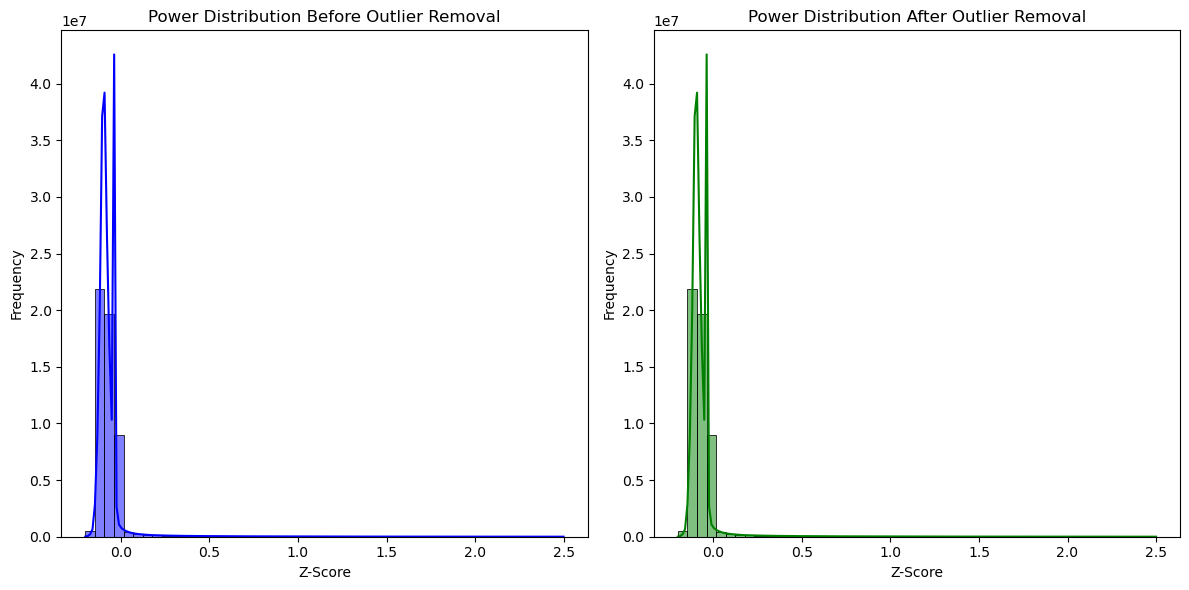

In [19]:
sample_power_processed = remove_outliers_zscored(sample_power_zscored.copy(), z_threshold=2.5)

### Get average, std and median z-scored power 

In [23]:
sample_mean_ppower, sample_std_ppower, sample_median_ppower = average_power(sample_power_processed)  

### Plot average PSD 
Consider that power data was collected between -0.5 and 1 secs in relation to SWR onset.
However we are only interested in showing between -0.5 sec and 0.5 sec. 

In [24]:
# Create x-ticks labels
x_tick_labels = sample_times[0:11]-0.5
print(x_tick_labels)

[-0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4  0.5]


In [25]:
# Check max and min average z-scored power values to adjust vmin and vmax
print(sample_mean_ppower.min(), sample_mean_ppower.max())

-0.09000848301352554 0.9286234426294562


Filtered Frequency bins: [ 0.          2.89351852  5.78703704  8.68055556 11.57407407 14.46759259
 17.36111111 20.25462963 23.14814815 26.04166667 28.93518519 31.8287037
 34.72222222 37.61574074 40.50925926 43.40277778 46.2962963  49.18981481
 52.08333333 54.97685185 57.87037037 60.76388889]
Time bins: [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


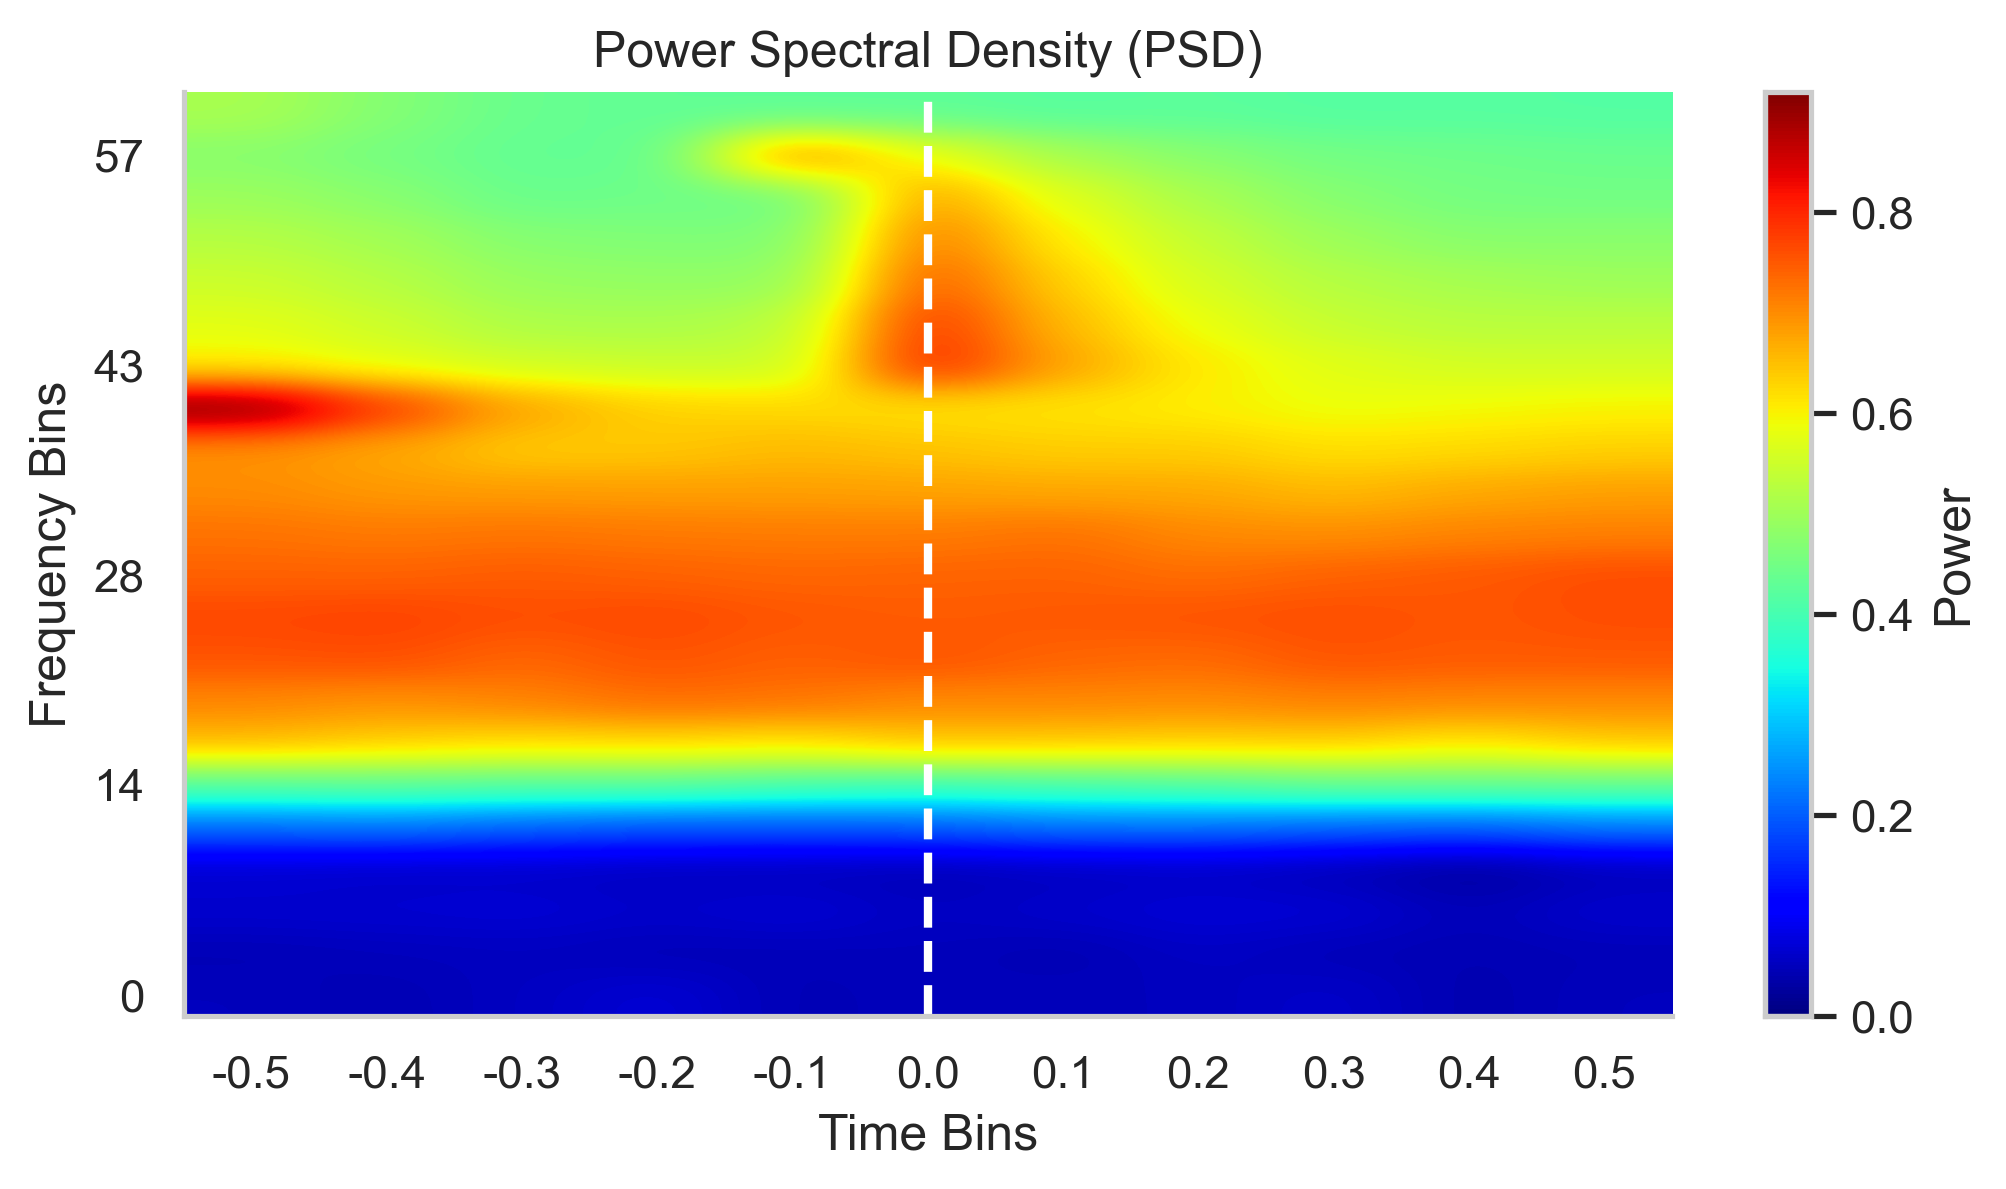

In [198]:
plot_psd_band(
    sample_times, sample_freqs, sample_mean_ppower, 
    ylim=(0,63), x_tick_labels=x_tick_labels, vmin=0, vmax=0.92)

# To add horizontal lines if needed
#plt.axhline(y=13, color='lightgray', linestyle=':', linewidth=1)
#plt.axhline(y=16, color='lightgray', linestyle=':', linewidth=1)

### Plot median PSD

In [199]:
# Check max and min median z-scored power values to adjust vmin and vmax
print(sample_mean_ppower.min(), sample_mean_ppower.max())

-0.09000848301352554 0.9286234426294562


Filtered Frequency bins: [ 0.          2.89351852  5.78703704  8.68055556 11.57407407 14.46759259
 17.36111111 20.25462963 23.14814815 26.04166667 28.93518519 31.8287037
 34.72222222 37.61574074 40.50925926 43.40277778 46.2962963  49.18981481
 52.08333333 54.97685185 57.87037037 60.76388889]
Time bins: [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


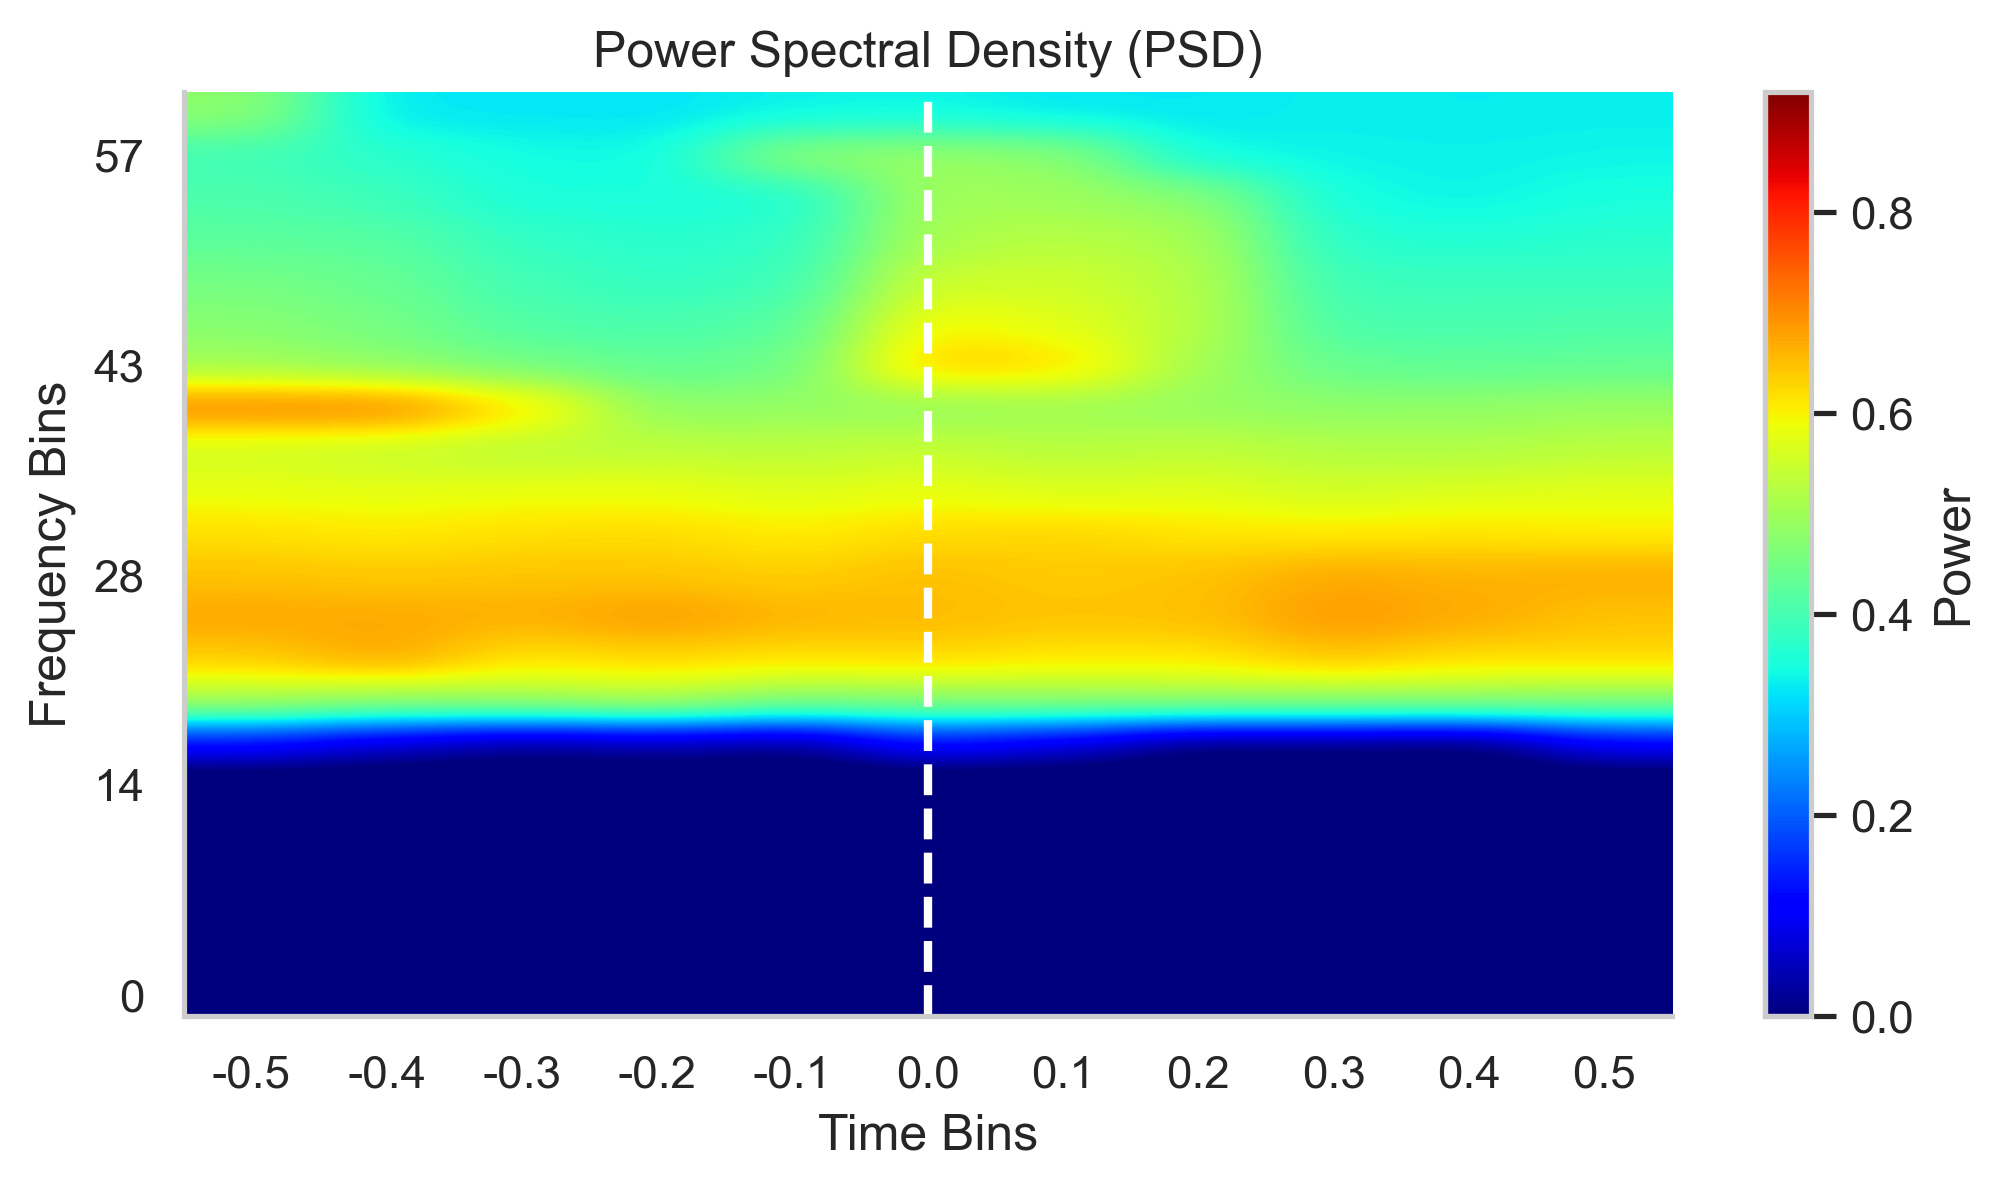

In [200]:
plot_psd_band(
   sample_times, sample_freqs, sample_median_ppower, 
    ylim=(0,63), x_tick_labels=x_tick_labels, vmin=0, vmax=0.92)

# To add horizontal lines if needed
#plt.axhline(y=15, color='white', linestyle=':', linewidth=1)
#plt.axhline(y=16, color='white', linestyle=':', linewidth=1)

### Plot median and average z-scored power values across time bins 

In [201]:
# Convert to a dataframe with long format 
# Assumes the reshaping made to calculate power maintains order of  ripples and tetrodes  - Ask chatgpt
sample_ppower_df = convert_to_long_format(
     sample_power_processed, time_bin_values=sample_times-.5, frequency_bin_values=sample_freqs, 
    ripple_labels = ripple_numbers, tetrode_labels = tetrodes
)

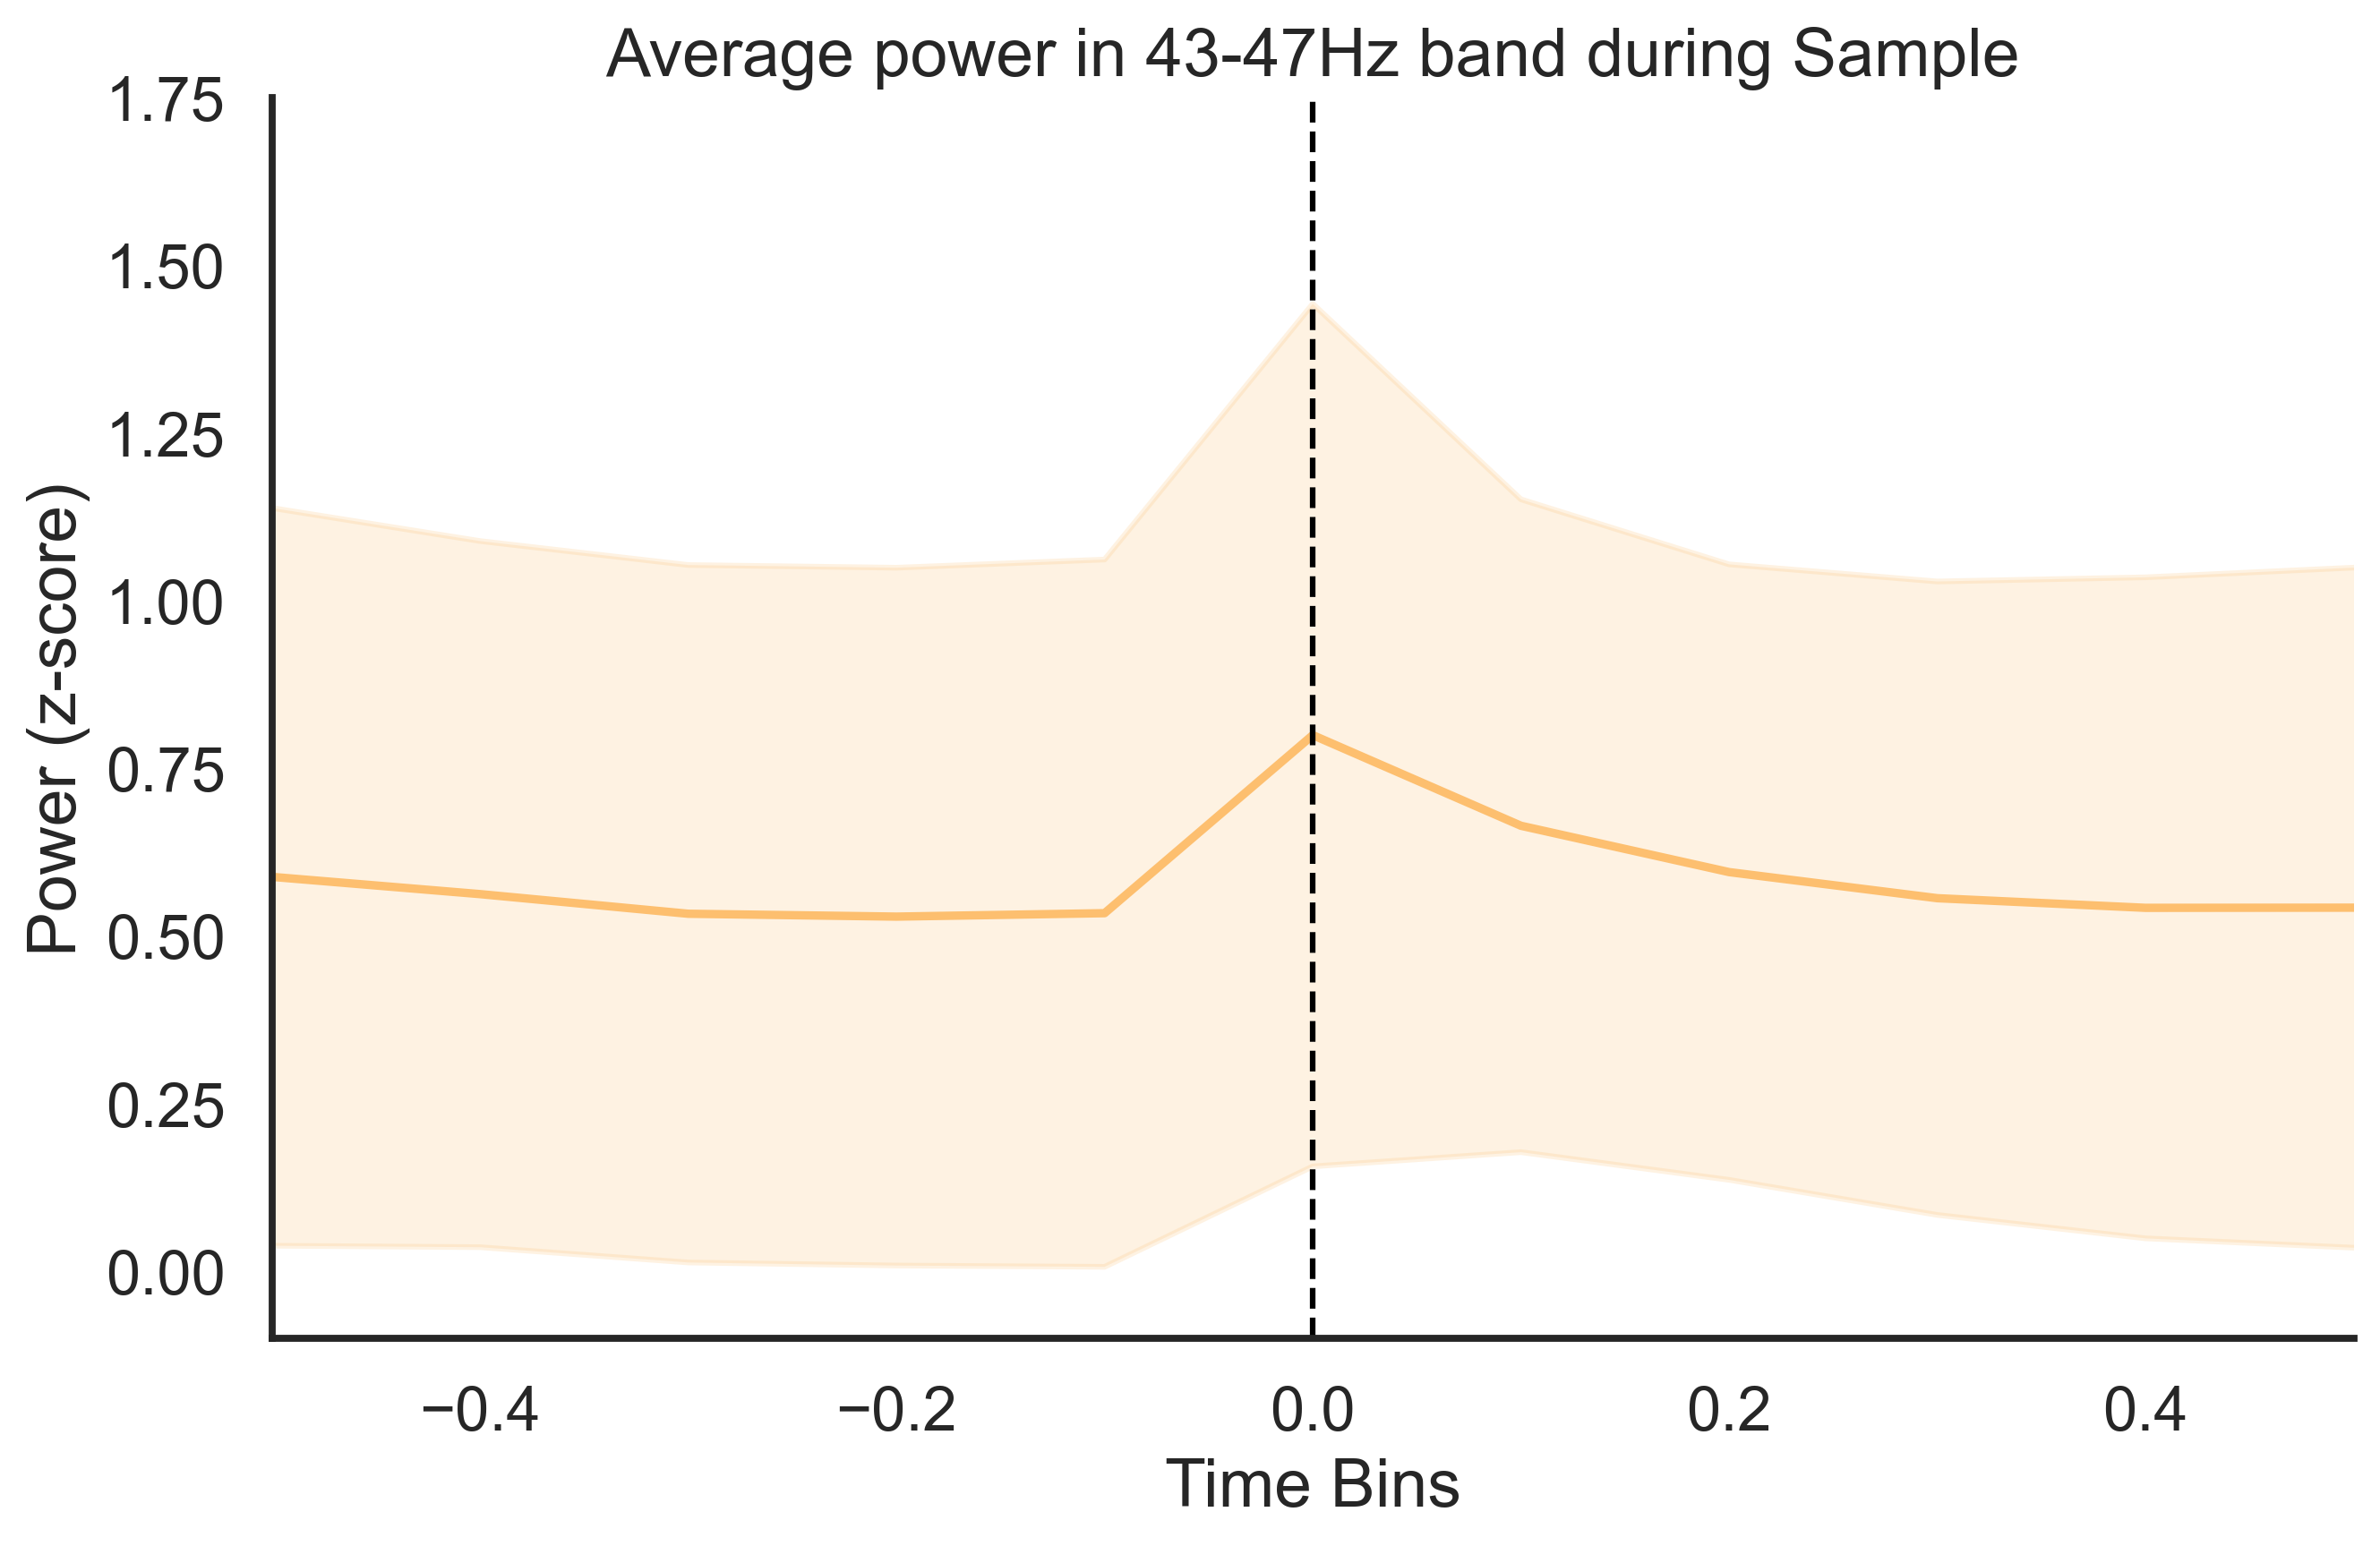

In [204]:
plot_average_power(
    sample_ppower_df, 
    band=(43,47),
    title='Average power in 43-47Hz band during Sample', 
    color=color, 
    ylim=(-0.1, 1.75), 
    xlim=(-0.5,0.5)
)

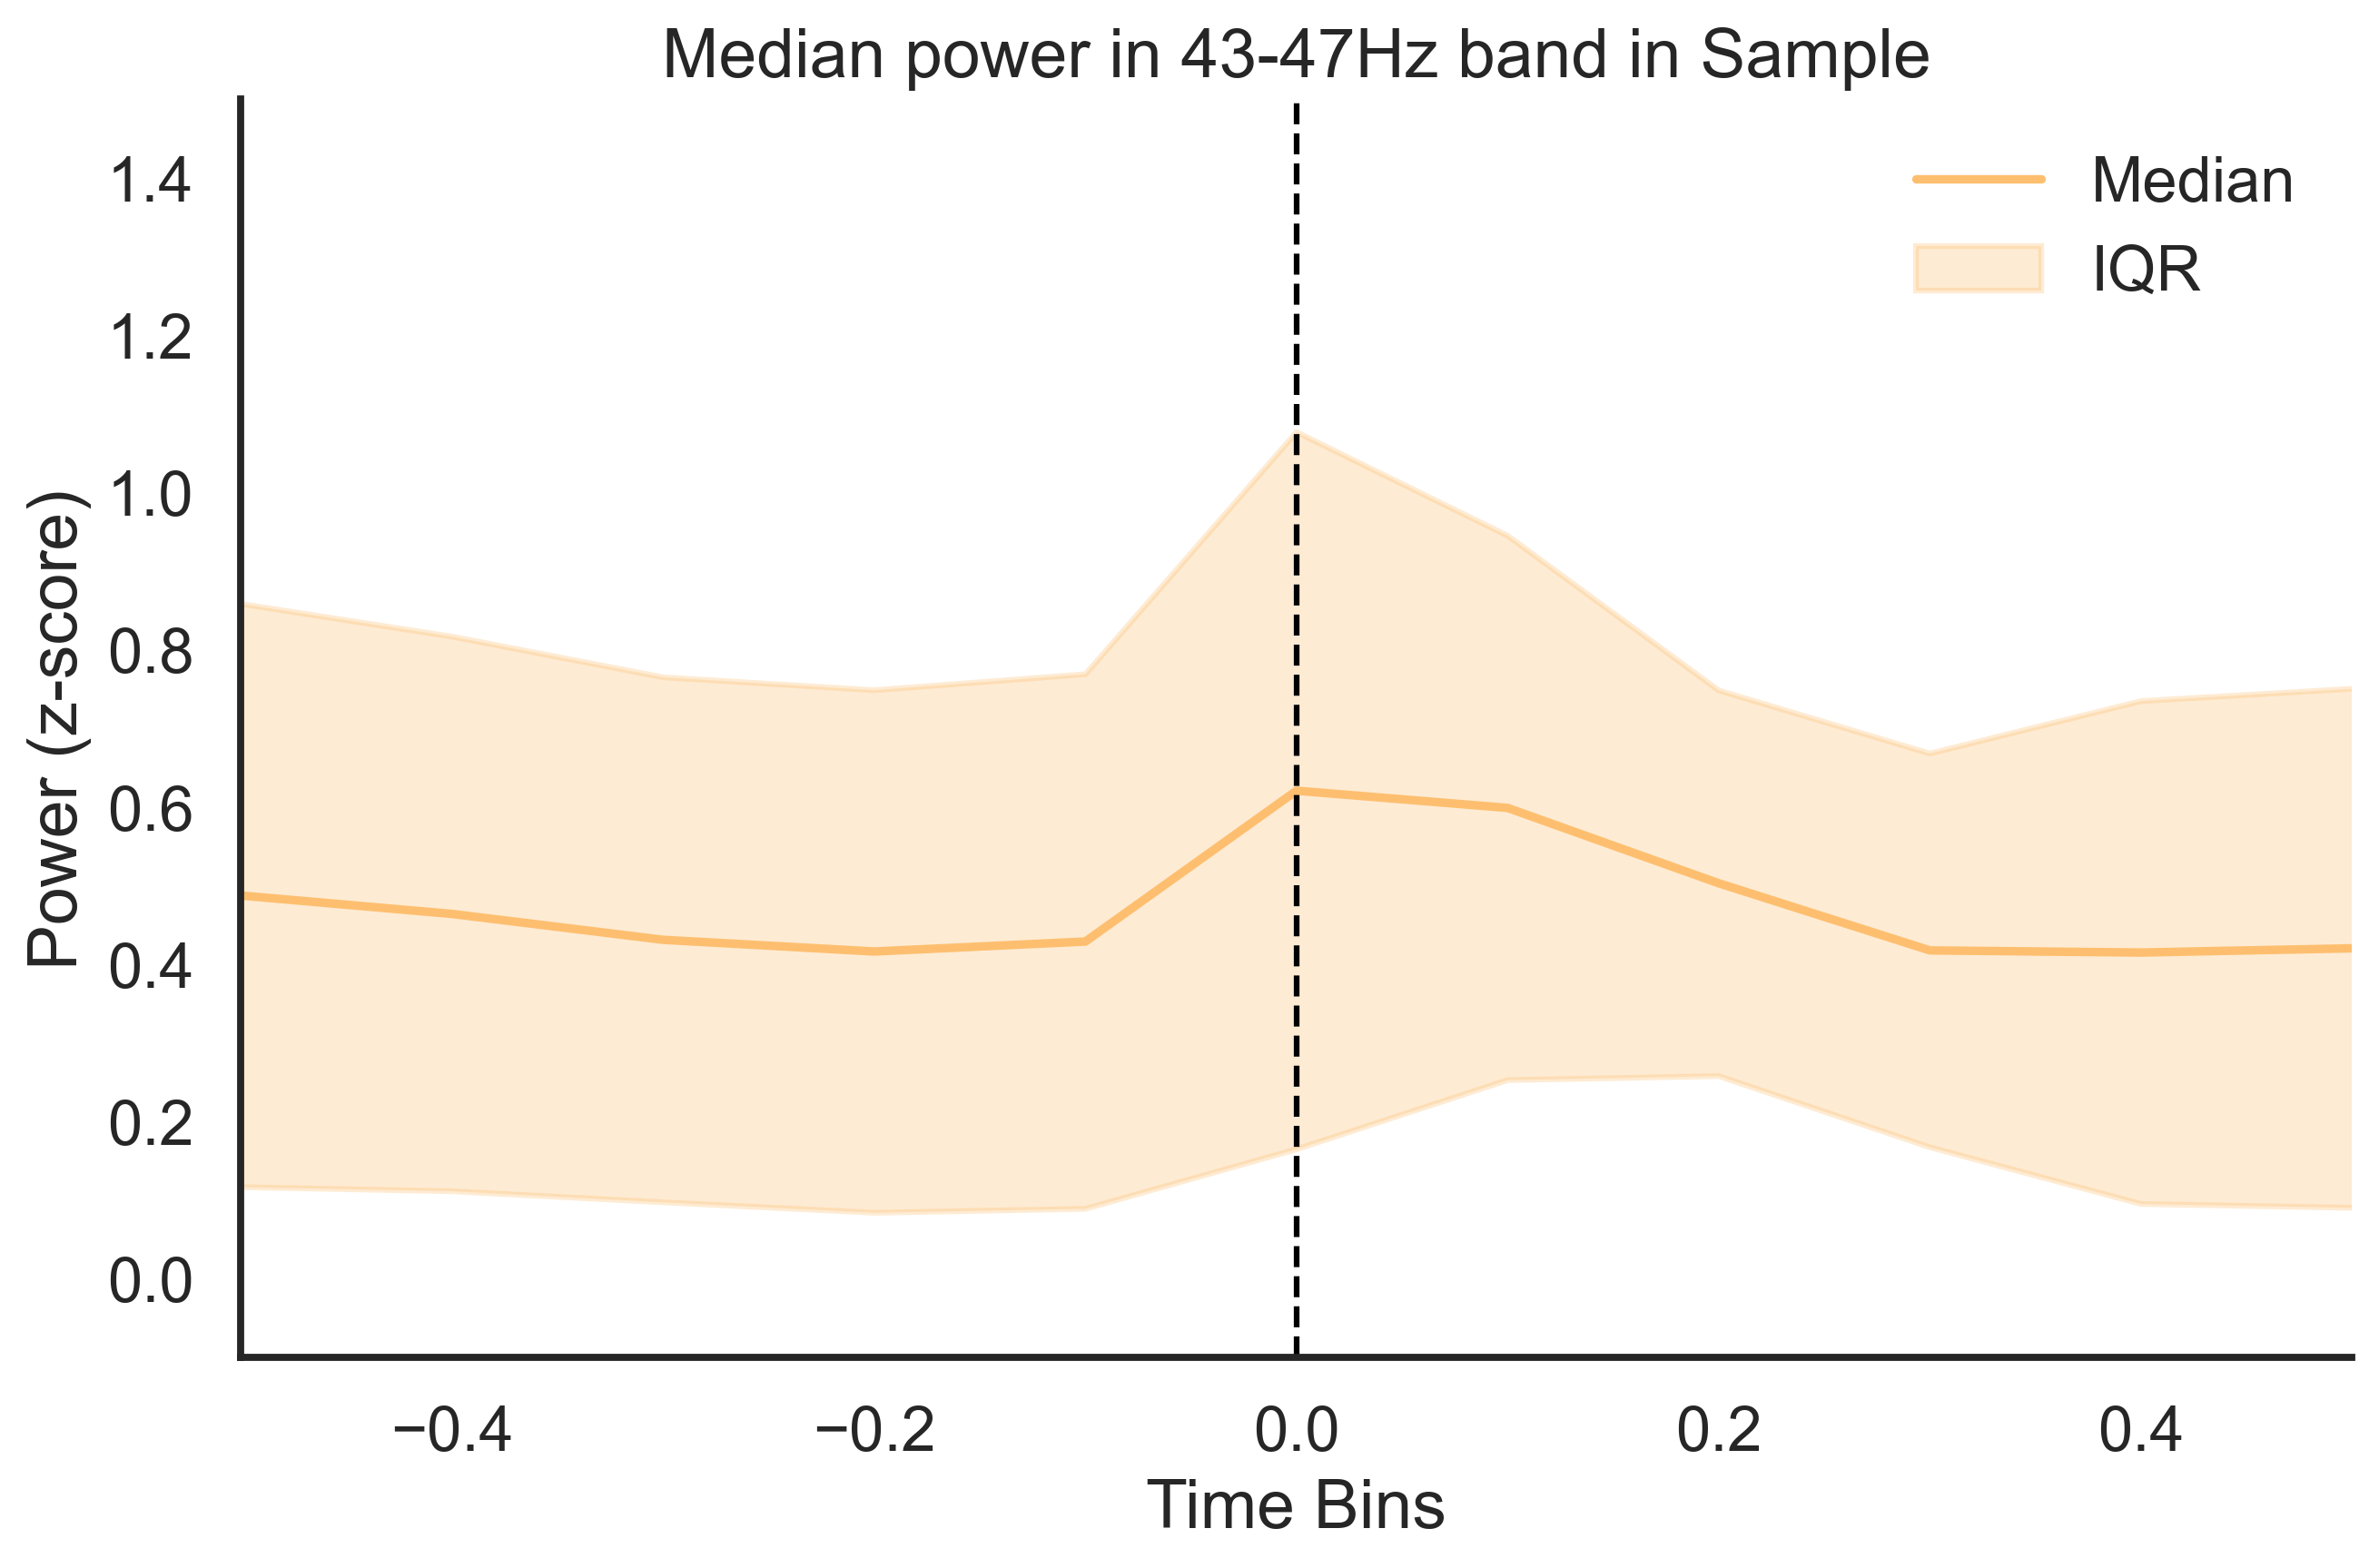

In [203]:
plot_median_power(
    sample_ppower_df, 
    band=(43,47),
    title='Median power in 43-47Hz band in Sample', 
    color=color, 
    ylim=(-0.1, 1.5), 
    xlim=(-0.5,0.5)
)

### Pairwise differences
From the information above, it appears that there is a potentially relevant z-scored power change in the first two timebins following ripple start. We'll compare time bin 0 and 0.1 to the previous time bin before ripple occurrence

In [205]:
# Label timepoints of interest to compare z-scored power pairwise differences
sample_ppower_df.loc[np.round(sample_ppower_df.time_bins, 1) ==-0.1, 'time_points']= '1' 
sample_ppower_df.loc[np.round(sample_ppower_df.time_bins,1) == 0, 'time_points']= '2' 
sample_ppower_df.loc[np.round(sample_ppower_df.time_bins,1) == 0.1, 'time_points']= '3'    

In [206]:
# Confirm labelling
sample_ppower_df[['time_bins', 'time_points']].dropna().drop_duplicates()

,time_bins,time_points
12458880,-0.1,1
15573600,0.0,2
18688320,0.1,3


[-2.00000000e+00 -1.90000000e+00 -1.80000000e+00 -1.70000000e+00
 -1.60000000e+00 -1.50000000e+00 -1.40000000e+00 -1.30000000e+00
 -1.20000000e+00 -1.10000000e+00 -1.00000000e+00 -9.00000000e-01
 -8.00000000e-01 -7.00000000e-01 -6.00000000e-01 -5.00000000e-01
 -4.00000000e-01 -3.00000000e-01 -2.00000000e-01 -1.00000000e-01
  1.77635684e-15  1.00000000e-01  2.00000000e-01  3.00000000e-01
  4.00000000e-01  5.00000000e-01  6.00000000e-01  7.00000000e-01
  8.00000000e-01  9.00000000e-01  1.00000000e+00  1.10000000e+00
  1.20000000e+00  1.30000000e+00  1.40000000e+00  1.50000000e+00
  1.60000000e+00  1.70000000e+00  1.80000000e+00  1.90000000e+00
  2.00000000e+00]


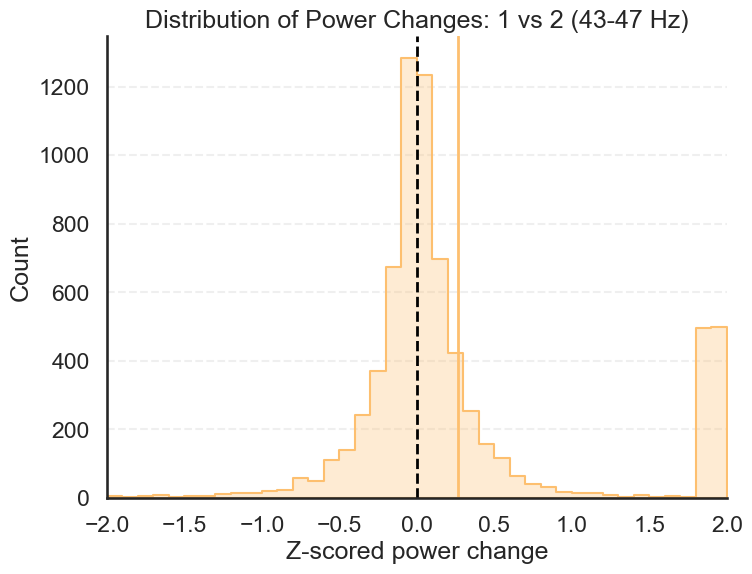

In [207]:
# Plot pairwise differences between baseline (timepoint 1) and first time bin of interest
# For band of interest(43-47Hz)

changes, df_tp1, df_tp2 = analyze_specific_power_change(
    sample_ppower_df, 
    ('1','2'), 
    band=(43,47), 
    color=phase_palette[1], 
    bins=(-2, 2, 0.1), 
    xlim=(-2,2)
)

The plot above hows a specific group of pairwise differences that clearly deviate from the rest of the distribution. To which trials to these pairwise differences belong to?

In [235]:
# Check characteristics of trials in subpopulation
high_diff_positions = np.where(changes['Changes']>1.9)
high_change_ripples = df_tp2.iloc[high_diff_positions]['ripple_nr'].unique()

In [237]:
# Confirm they are all from Sample
ripple_data[ripple_data.ripple_nr.isin(high_change_ripples)].phase.unique()

array(['Sample'], dtype=object)

In [239]:
print(
    'Sessions: {}, Rats: {}'.format(
        ripple_data.session_code.unique(), 
        ripple_data.rat_code.unique()
    )
)

Sessions: [20191113131818 20191117150748 20191105174624 20190126160731
 20190127105419 20190128135858 20190128142936 20190128193951
 20190128201036 20190128190601 20190129013902 20180504094832
 20180505150034], Rats: ['HOM' 'MAG' 'NAP']


The highest pairwise differences are coming from ripples collected in all 3 rats, across multiple sessions.

It there anything distinctive about them? Such as ripple duration? Or trial outcome?

In [243]:
# Check what was their trial outcome
ripple_data[ripple_data.ripple_nr.isin(high_change_ripples)].groupby('outcome')['start_time'].count()

outcome
0.0     7
1.0    90
Name: start_time, dtype: int64

Most of the ripples where pairwise power increases occurred are associated with a positive trial outcome (~93.8%)

In [257]:
# Check same thing for all sample ripples
ripple_data[ripple_data.phase=='Sample'].groupby('outcome')['start_time'].count()

outcome
0.0     73
1.0    442
Name: start_time, dtype: int64

But the distribution of outcomes for other sample ripples is similar, with ~85% with a positive trial outcome too
-- CREATE PLOT COMPARING OUTCOMES FROM SAMPLE AND PAIRWISE DIFFERENCES 

In [252]:
# Check their duration
ripple_data[ripple_data.ripple_nr.isin(high_change_ripples)]['duration_ms'].describe()

count     97.000000
mean      72.859794
std       39.142210
min       23.800000
25%       45.000000
50%       61.800000
75%       89.400000
max      200.800000
Name: duration_ms, dtype: float64

In [253]:
# Check their duration
ripple_data['duration_ms'].describe()

count    1578.000000
mean       68.737262
std        35.782637
min        21.200000
25%        44.400000
50%        60.000000
75%        83.750000
max       340.400000
Name: duration_ms, dtype: float64

Their duration distribution seems to overlap - CREATE A PLOT FOR THIS